In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv
import os
load_dotenv()
PROJECT_ROOT = os.getenv('PROJECT_ROOT')

# Add PROJECT_ROOT to the Python path
import sys
sys.path.append(PROJECT_ROOT)

Declaring departure and arrival airports

In [3]:
import pandas as pd

ORIGIN_ICAO = 'EGLL'
DEST_ICAO = 'UKBB'
ORIGIN_RWY = '09R'
DEST_RWY = '18R'

airports_df = pd.read_csv(os.path.join(PROJECT_ROOT, "data", "airac", "airports.csv"))


# Get the latitude and longitude of the origin and destination
origin_lat = airports_df[airports_df['icao'] == ORIGIN_ICAO]['latitude'].values[0]
origin_lon = airports_df[airports_df['icao'] == ORIGIN_ICAO]['longitude'].values[0]
dest_lat = airports_df[airports_df['icao'] == DEST_ICAO]['latitude'].values[0]
dest_lon = airports_df[airports_df['icao'] == DEST_ICAO]['longitude'].values[0]
# Origin and destination airport names
origin_name = airports_df[airports_df['icao'] == ORIGIN_ICAO]['name'].values[0]
dest_name = airports_df[airports_df['icao'] == DEST_ICAO]['name'].values[0]

print(f'Origin: {ORIGIN_ICAO} - {origin_name} ({origin_lat}, {origin_lon}, {ORIGIN_RWY})')
print(f'Destination: {DEST_ICAO} - {dest_name} ({dest_lat}, {dest_lon}, {DEST_RWY})')

Origin: EGLL - HEATHROW (51.4775, -0.461389, 09R)
Destination: UKBB - BORYSPIL INTL (50.344722, 30.893333, 18R)


Building the navigation graph

In [4]:
from nav_graph import generate_navigraph

route_graph = generate_navigraph(ORIGIN_ICAO, DEST_ICAO, origin_lat, origin_lon, dest_lat, dest_lon,
                                  ORIGIN_RWY, DEST_RWY,
                                  w_dct=1.0, w_fra=1.0, w_proc=0.2)


Subsetting the ATS graph to the great circle path between origin and destination...


Adding edges to subset: 100%|██████████| 25011/25011 [00:00<00:00, 837320.81it/s]


ATS graph loaded. Nodes: 1670, edges: 3817
Building FRA routing options...
Found 1037 FRA points within 100nm of the great circle path between origin and destination.          
Merging these into the ATS graph...
223 FRA points renamed for BALTIC & FRAIT & SECSI & SEE FRA


BALTIC & FRAIT & SECSI & SEE FRA: 100%|██████████| 267/267 [00:00<00:00, 522.49it/s]


35 FRA points renamed for BELFRA


BELFRA: 100%|██████████| 39/39 [00:00<00:00, 5559.52it/s]


90 FRA points renamed for BOREALIS FRA


BOREALIS FRA: 100%|██████████| 202/202 [00:00<00:00, 1138.38it/s]


31 FRA points renamed for EDMM EAST


EDMM EAST: 100%|██████████| 35/35 [00:00<00:00, 6981.20it/s]


44 FRA points renamed for EDUU EAST


EDUU EAST: 100%|██████████| 49/49 [00:00<00:00, 6978.40it/s]


53 FRA points renamed for EDUU NORTH


EDUU NORTH: 100%|██████████| 72/72 [00:00<00:00, 3812.43it/s]


10 FRA points renamed for EDUU WEST


EDUU WEST: 100%|██████████| 16/16 [00:00<?, ?it/s]


25 FRA points renamed for EDWW EAST


EDWW EAST: 100%|██████████| 30/30 [00:00<00:00, 9977.73it/s]


2 FRA points renamed for LFFRANW


LFFRANW: 100%|██████████| 8/8 [00:00<?, ?it/s]


130 FRA points renamed for MUAC FRA


MUAC FRA: 100%|██████████| 186/186 [00:00<00:00, 812.93it/s]


127 FRA points renamed for UKNESFRA


UKNESFRA: 100%|██████████| 133/133 [00:00<00:00, 808.11it/s]


FRA graph merged into ATS graph. Nodes: 2668, edges: 121054
Computing cost for the ATS-FRA route graph...


Adding edges to subset: 100%|██████████| 121054/121054 [00:00<00:00, 322818.88it/s]


Adding SID and STAR graphs to the subset...
Route graph subset created. Nodes: 2924, edges: 121334
Great circle distance between origin and destination: 1179.84 nm


# Shortest Path as Base Route

Find the shortest path between origin and destination

In [5]:
import networkx as nx
from utils.flightplans import format_flightplan
from utils.haversine import haversine_distance

# Find the shortest path between origin and destination
origin_node = f"{ORIGIN_ICAO}_{ORIGIN_RWY}"
dest_node = f"{DEST_ICAO}_{DEST_RWY}"

# Check if the nodes exist in the graph
if origin_node not in route_graph.nodes:
    print(f"Origin node {origin_node} not found in graph. Available nodes for {ORIGIN_ICAO}:")
    for node in route_graph.nodes:
        if node.startswith(ORIGIN_ICAO):
            print(f"  {node}")
    # Try to find an alternative
    for node in route_graph.nodes:
        if node.startswith(ORIGIN_ICAO):
            origin_node = node
            print(f"Using {origin_node} as origin node instead")
            break

if dest_node not in route_graph.nodes:
    print(f"Destination node {dest_node} not found in graph. Available nodes for {DEST_ICAO}:")
    for node in route_graph.nodes:
        if node.startswith(DEST_ICAO):
            print(f"  {node}")
    # Try to find an alternative
    for node in route_graph.nodes:
        if node.startswith(DEST_ICAO):
            dest_node = node
            print(f"Using {dest_node} as destination node instead")
            break

# Find the shortest path
try:
    shortest_path = nx.shortest_path(route_graph, source=origin_node, target=dest_node, weight='cost')
    print(f"Shortest path found with {len(shortest_path)} waypoints")
    
    # Convert shortest path into list of dictionaries with edge information
    result = []
    cumulative_cost = 0
    cumulative_distance = 0
    for i in range(len(shortest_path)-1):
        from_node = shortest_path[i]
        to_node = shortest_path[i+1]
        
        # Get node coordinates
        from_lat = float(route_graph.nodes[from_node]['lat'])
        from_lon = float(route_graph.nodes[from_node]['lon'])
        to_lat = float(route_graph.nodes[to_node]['lat'])
        to_lon = float(route_graph.nodes[to_node]['lon'])
        
        # Get edge data
        edge_data = route_graph.edges[from_node, to_node]
        cumulative_cost += edge_data['cost']
        cumulative_distance += edge_data.get('distance', haversine_distance(from_lat, from_lon, to_lat, to_lon))

        result.append({
            'from_node': from_node,
            'to_node': to_node,
            'from_lat': from_lat,
            'from_lon': from_lon,
            'to_lat': to_lat,
            'to_lon': to_lon,
            'distance': edge_data.get('distance', haversine_distance(from_lat, from_lon, to_lat, to_lon)),
            'cost': edge_data['cost'],
            'edge_type': edge_data['edge_type'],
            'airway': edge_data['airway'],
        })

    # Print the flight plan
    print(format_flightplan(result))

except nx.NetworkXNoPath:
    print(f"No path found between {origin_node} and {dest_node}")
except Exception as e:
    print(f"Error finding path: {e}")

Origin node EGLL_09R not found in graph. Available nodes for EGLL:
  EGLL
Using EGLL as origin node instead
Destination node UKBB_18R not found in graph. Available nodes for UKBB:
  UKBB
Using UKBB as destination node instead
Shortest path found with 26 waypoints
EGLL CPT5J WOD BPK Q295 BRAIN M197 REDFA DERAM L980 POLON M70 OKROT SLV SLV2J UKBB


# SPLICE Operation

In [6]:
print(f'Shortest path: {shortest_path[:3]}')
print(f'Length of shortest path: {len(shortest_path)}')

Shortest path: ['EGLL', 'CPT5J_D130B', 'CPT5J_D253K']
Length of shortest path: 26


In [7]:
from planner2 import minimum_description_route, check_ac_valid
shortest_path_str = ' '.join(shortest_path)
print('SHORTEST PATH: ',shortest_path_str)
route_minimum = minimum_description_route(route_graph, shortest_path)
print('MINIMUM DESCRIPTION ROUTE: ', ' '.join(route_minimum))


SHORTEST PATH:  EGLL CPT5J_D130B CPT5J_D253K CPT5J_WOD WOD BPK TOTRI MATCH BRAIN GASBA RATLO REDFA ISMEF HLZ ARSAP DERAM POLON SOMOX TOLPA OKROT SLV SLV2J_SLV SLV2J_SL32B SLV2J_SLV50 SLV2J_D266B UKBB
MINIMUM DESCRIPTION ROUTE:  EGLL MATCH GASBA RATLO ISMEF ARSAP DERAM POLON TOLPA OKROT SLV2J_D266B UKBB


In [8]:
a = 5
b = 6
c = 6
print(f'Keep until {shortest_path[a-1]} ({a-1}) (inclusive) and from {shortest_path[c]} ({c}) (inclusive)')
print(f'{" ".join(shortest_path[:a])} ...?... {" ".join(shortest_path[c:])}')

ac_valid, key_node_count, key_nodes = check_ac_valid(a, c, shortest_path, route_minimum)
print(f'AC valid: {ac_valid}, Key node count: {key_node_count}')
print(f'Key nodes: {key_nodes}')

Keep until WOD (4) (inclusive) and from TOTRI (6) (inclusive)
EGLL CPT5J_D130B CPT5J_D253K CPT5J_WOD WOD ...?... TOTRI MATCH BRAIN GASBA RATLO REDFA ISMEF HLZ ARSAP DERAM POLON SOMOX TOLPA OKROT SLV SLV2J_SLV SLV2J_SL32B SLV2J_SLV50 SLV2J_D266B UKBB
AC valid: True, Key node count: 0
Key nodes: []


In [9]:
from planner2 import find_admissible_pivot_nodes, collapse_pivot_options

nodes_to_exclude = set(shortest_path[:a]) | set(shortest_path[c:])
admissible_nodes_forward, forward_distances = find_admissible_pivot_nodes(route_graph, shortest_path[a-1], nodes_to_exclude,
                                                                          max_depth=8, prevent_backtracking = True, origin = shortest_path[a-1], dest = shortest_path[c])

print(f'Found {len(admissible_nodes_forward)} admissible pivot nodes for forward direction')

Found 1313 admissible pivot nodes for forward direction


In [10]:
admissible_nodes_backward, backward_distances = find_admissible_pivot_nodes(route_graph, shortest_path[c], nodes_to_exclude,
                                                                          max_depth=8, prevent_backtracking = True, origin = shortest_path[a-1], dest = shortest_path[c], direction = 'backward')
print(f'Found {len(admissible_nodes_backward)} admissible pivot nodes for backward direction')

Found 283 admissible pivot nodes for backward direction


In [11]:
# # Create a scatter plot of admissible_nodes_backward using cartopy
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# import numpy as np

# # Extract coordinates for backward admissible nodes
# backward_lats = []
# backward_lons = []
# for node in admissible_nodes_backward:
#     backward_lats.append(route_graph.nodes[node]['lat'])
#     backward_lons.append(route_graph.nodes[node]['lon'])

# # Create a figure with a map projection
# plt.figure(figsize=(10, 8))
# ax = plt.axes(projection=ccrs.PlateCarree())

# # Add map features
# ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.add_feature(cfeature.LAND, facecolor='lightgray')
# ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# # Plot the backward admissible nodes
# ax.scatter(backward_lons, backward_lats, c='red', s=30, alpha=0.7, 
#            transform=ccrs.PlateCarree(), label='Backward Admissible Nodes')

# # Add the original route for context
# # route_lats = [route_graph.nodes[node]['lat'] for node in shortest_path]
# # route_lons = [route_graph.nodes[node]['lon'] for node in shortest_path]
# # ax.plot(route_lons, route_lats, 'b-', linewidth=2, 
# #         transform=ccrs.PlateCarree(), label='Original Route')

# # Highlight the specific nodes a-1 and c
# ax.scatter([route_graph.nodes[shortest_path[a-1]]['lon']], 
#            [route_graph.nodes[shortest_path[a-1]]['lat']], 
#            c='green', s=100, marker='*', edgecolor='black', 
#            transform=ccrs.PlateCarree(), label=f'Node {a-1}')

# ax.scatter([route_graph.nodes[shortest_path[c]]['lon']], 
#            [route_graph.nodes[shortest_path[c]]['lat']], 
#            c='purple', s=100, marker='*', edgecolor='black', 
#            transform=ccrs.PlateCarree(), label=f'Node {c}')

# # Set the map extent based on the data
# buffer = 2  # degrees
# min_lon, max_lon = min(backward_lons) - buffer, max(backward_lons) + buffer
# min_lat, max_lat = min(backward_lats) - buffer, max(backward_lats) + buffer
# ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# # Add gridlines
# ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# # Add title and legend
# plt.title('Backward Admissible Nodes and Original Route')
# plt.legend(loc='upper left')

# plt.tight_layout()
# plt.show()


In [12]:
# Find the intersection of forward and backward admissible nodes
V = set(admissible_nodes_forward) & set(admissible_nodes_backward)
# We also remove all nodes that are part of a SID or STAR node (containing an underscore)
V = {v for v in V if '_' not in v}
# Create a dictionary of nodes with their forward and backward distances
V_distances = {v: {
    'forward_dist': forward_distances[v], 
    'backward_dist': backward_distances[v]
} for v in V}
V_distances_collapsed = collapse_pivot_options(V_distances)
V_collapsed = set(V_distances_collapsed.keys())

if len(key_nodes) == 0:
    # If key_nodes is empty, the current pivot is the one with lowest total distance in V_distances_collapsed
    old_pivot_node = min(V_distances_collapsed, key=lambda x: V_distances_collapsed[x]['forward_dist'][1] + V_distances_collapsed[x]['backward_dist'][1])
elif len(key_nodes) == 1: # len(key_nodes) == 1
    # If key_nodes is not empty, the current pivot is the one in key_nodes
    old_pivot_node = key_nodes[0]
else: # len(key_nodes) > 1
    raise ValueError(f'len(key_nodes) = {len(key_nodes)}, maximum is 1!')

print(f'Forward: {len(admissible_nodes_forward)} nodes can be considered; Backward: {len(admissible_nodes_backward)} nodes can be considered')
print(f'Overall {len(V)} nodes can be considered as a potential pivot (V set)')
print(f'After collapsing, {len(V_collapsed)} nodes can be considered as a potential pivot (V_collapsed set)')
print(f'Examples: {list(V_collapsed)[:5]}')
print(f'Old pivot: {old_pivot_node}')

Forward: 1313 nodes can be considered; Backward: 283 nodes can be considered
Overall 5 nodes can be considered as a potential pivot (V set)
After collapsing, 2 nodes can be considered as a potential pivot (V_collapsed set)
Examples: ['BPK', 'MODMI']
Old pivot: BPK


In [13]:
# Show the V_distances sorted by total distance from smallest to largest
sorted_V_distances = dict(sorted(V_distances_collapsed.items(), 
                                 key=lambda x: x[1]['forward_dist'][1] + x[1]['backward_dist'][1]))

# Print sorted V_distances with total distance
for node, distances in list(sorted_V_distances.items())[:10]:
    total_dist = distances['forward_dist'][1] + distances['backward_dist'][1]
    print(f"Node: {node}, Forward: {distances['forward_dist']}, Backward: {distances['backward_dist']}, Total: {total_dist}")


Node: BPK, Forward: (1, 33.8655136485195), Backward: (1, 11.37), Total: 45.2355136485195
Node: MODMI, Forward: (2, 37.74), Backward: (4, 45.45), Total: 83.19


Old pivot BPK probability: 0.5094874826879556


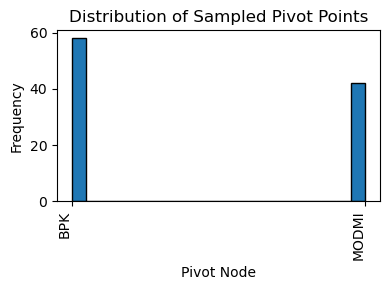

In [25]:
# Sample a pivot point
from planner2 import sample_pivot, compute_pivot_probabilities
pivot_probabilities = compute_pivot_probabilities(V_distances_collapsed, mu = 1000)
sampled_V, prob_sampled_V, old_pivot_prob = sample_pivot(V_distances_collapsed, pivot_probabilities, num_samples=100, old_pivot = old_pivot_node)
print(f'Old pivot {old_pivot_node} probability: {old_pivot_prob}')
# Plot histogram of sampled pivot points
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
plt.hist(sampled_V, bins=20, edgecolor='black')
plt.title('Distribution of Sampled Pivot Points')
plt.xlabel('Pivot Node')
plt.ylabel('Frequency')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()


In [29]:
from planner2 import replace_route_segment
from utils.flightplans import get_detailed_flightplan_from_waypoint_list

print(f'New pivot point: {sampled_V[2]}')
new_route, a_prime, c_prime, head_dups, tail_dups = replace_route_segment(route_graph, shortest_path, a, c, sampled_V[2])
new_route_detailed = get_detailed_flightplan_from_waypoint_list(route_graph, new_route)
print(f'New route: {format_flightplan(new_route_detailed)}')


New pivot point: MODMI
New route: EGLL CPT5J WOD UL612 MID UM185 BPK Q295 BRAIN M197 REDFA DERAM L980 POLON M70 OKROT SLV SLV2J UKBB


In [27]:
from planner2 import get_shortest_path
from_wod = get_shortest_path(route_graph, shortest_path[a-1], 'MODMI')
to_gasba = get_shortest_path(route_graph, 'MODMI', shortest_path[c])
print(f'{from_wod}')
print(f'{to_gasba}')


['WOD', 'MID', 'MODMI']
['MODMI', 'OCK', 'KOBBI', 'BPK', 'TOTRI']


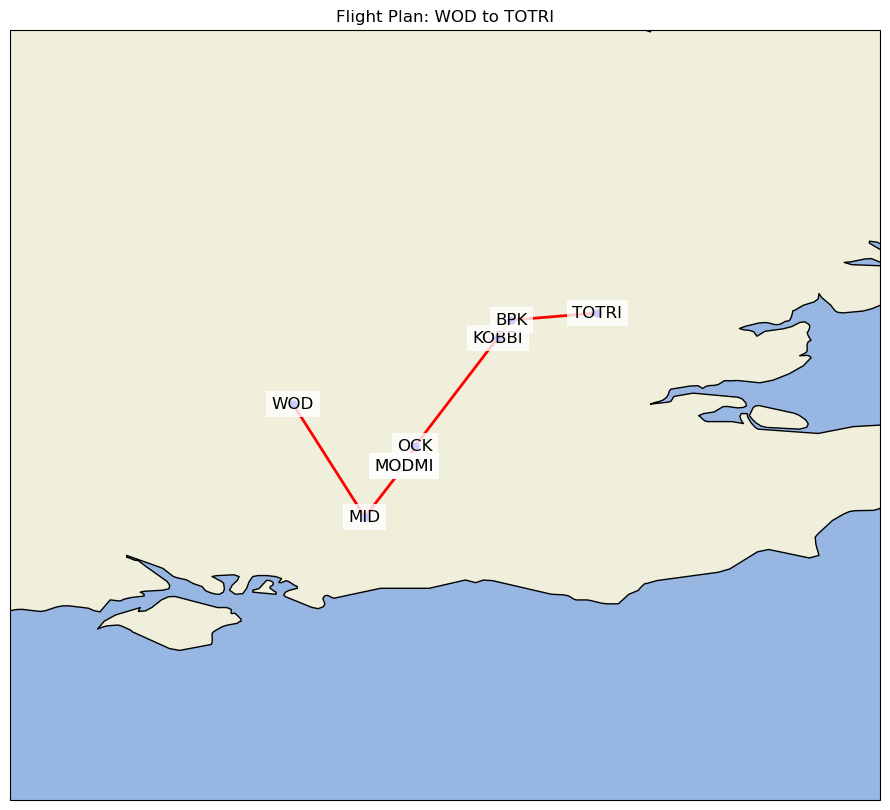

In [28]:
from utils.ploter import plot_flightplan2
plot_flightplan2(route_graph, from_wod + to_gasba)
